In [61]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r'../../Data/FinacialFeatures.csv'
flevel = json.load(open(r'../FeatureEngineering/feature_level.json'))

In [69]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [71]:
count = 0
for col in f_df.columns.values:
    nan_len = len(f_df.loc[f_df[col] == np.inf])
    count += nan_len
    if nan_len != 0:
        print(col)
count

营业成本(元)滚动增长_mean
管理费用(元)滚动增长_mean
投资流出滚动增长_mean
加权净资产收益率滚动增长_mean
净利率滚动增长_mean
总资产周转率(次)滚动增长_mean


196

In [64]:
df = pd.DataFrame()
df = nf_df.copy()

f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')
first_level = flevel['first_level']
first_level.append('企业编号')
first_level.append('企业总评分')
# df = df[first_level]
df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


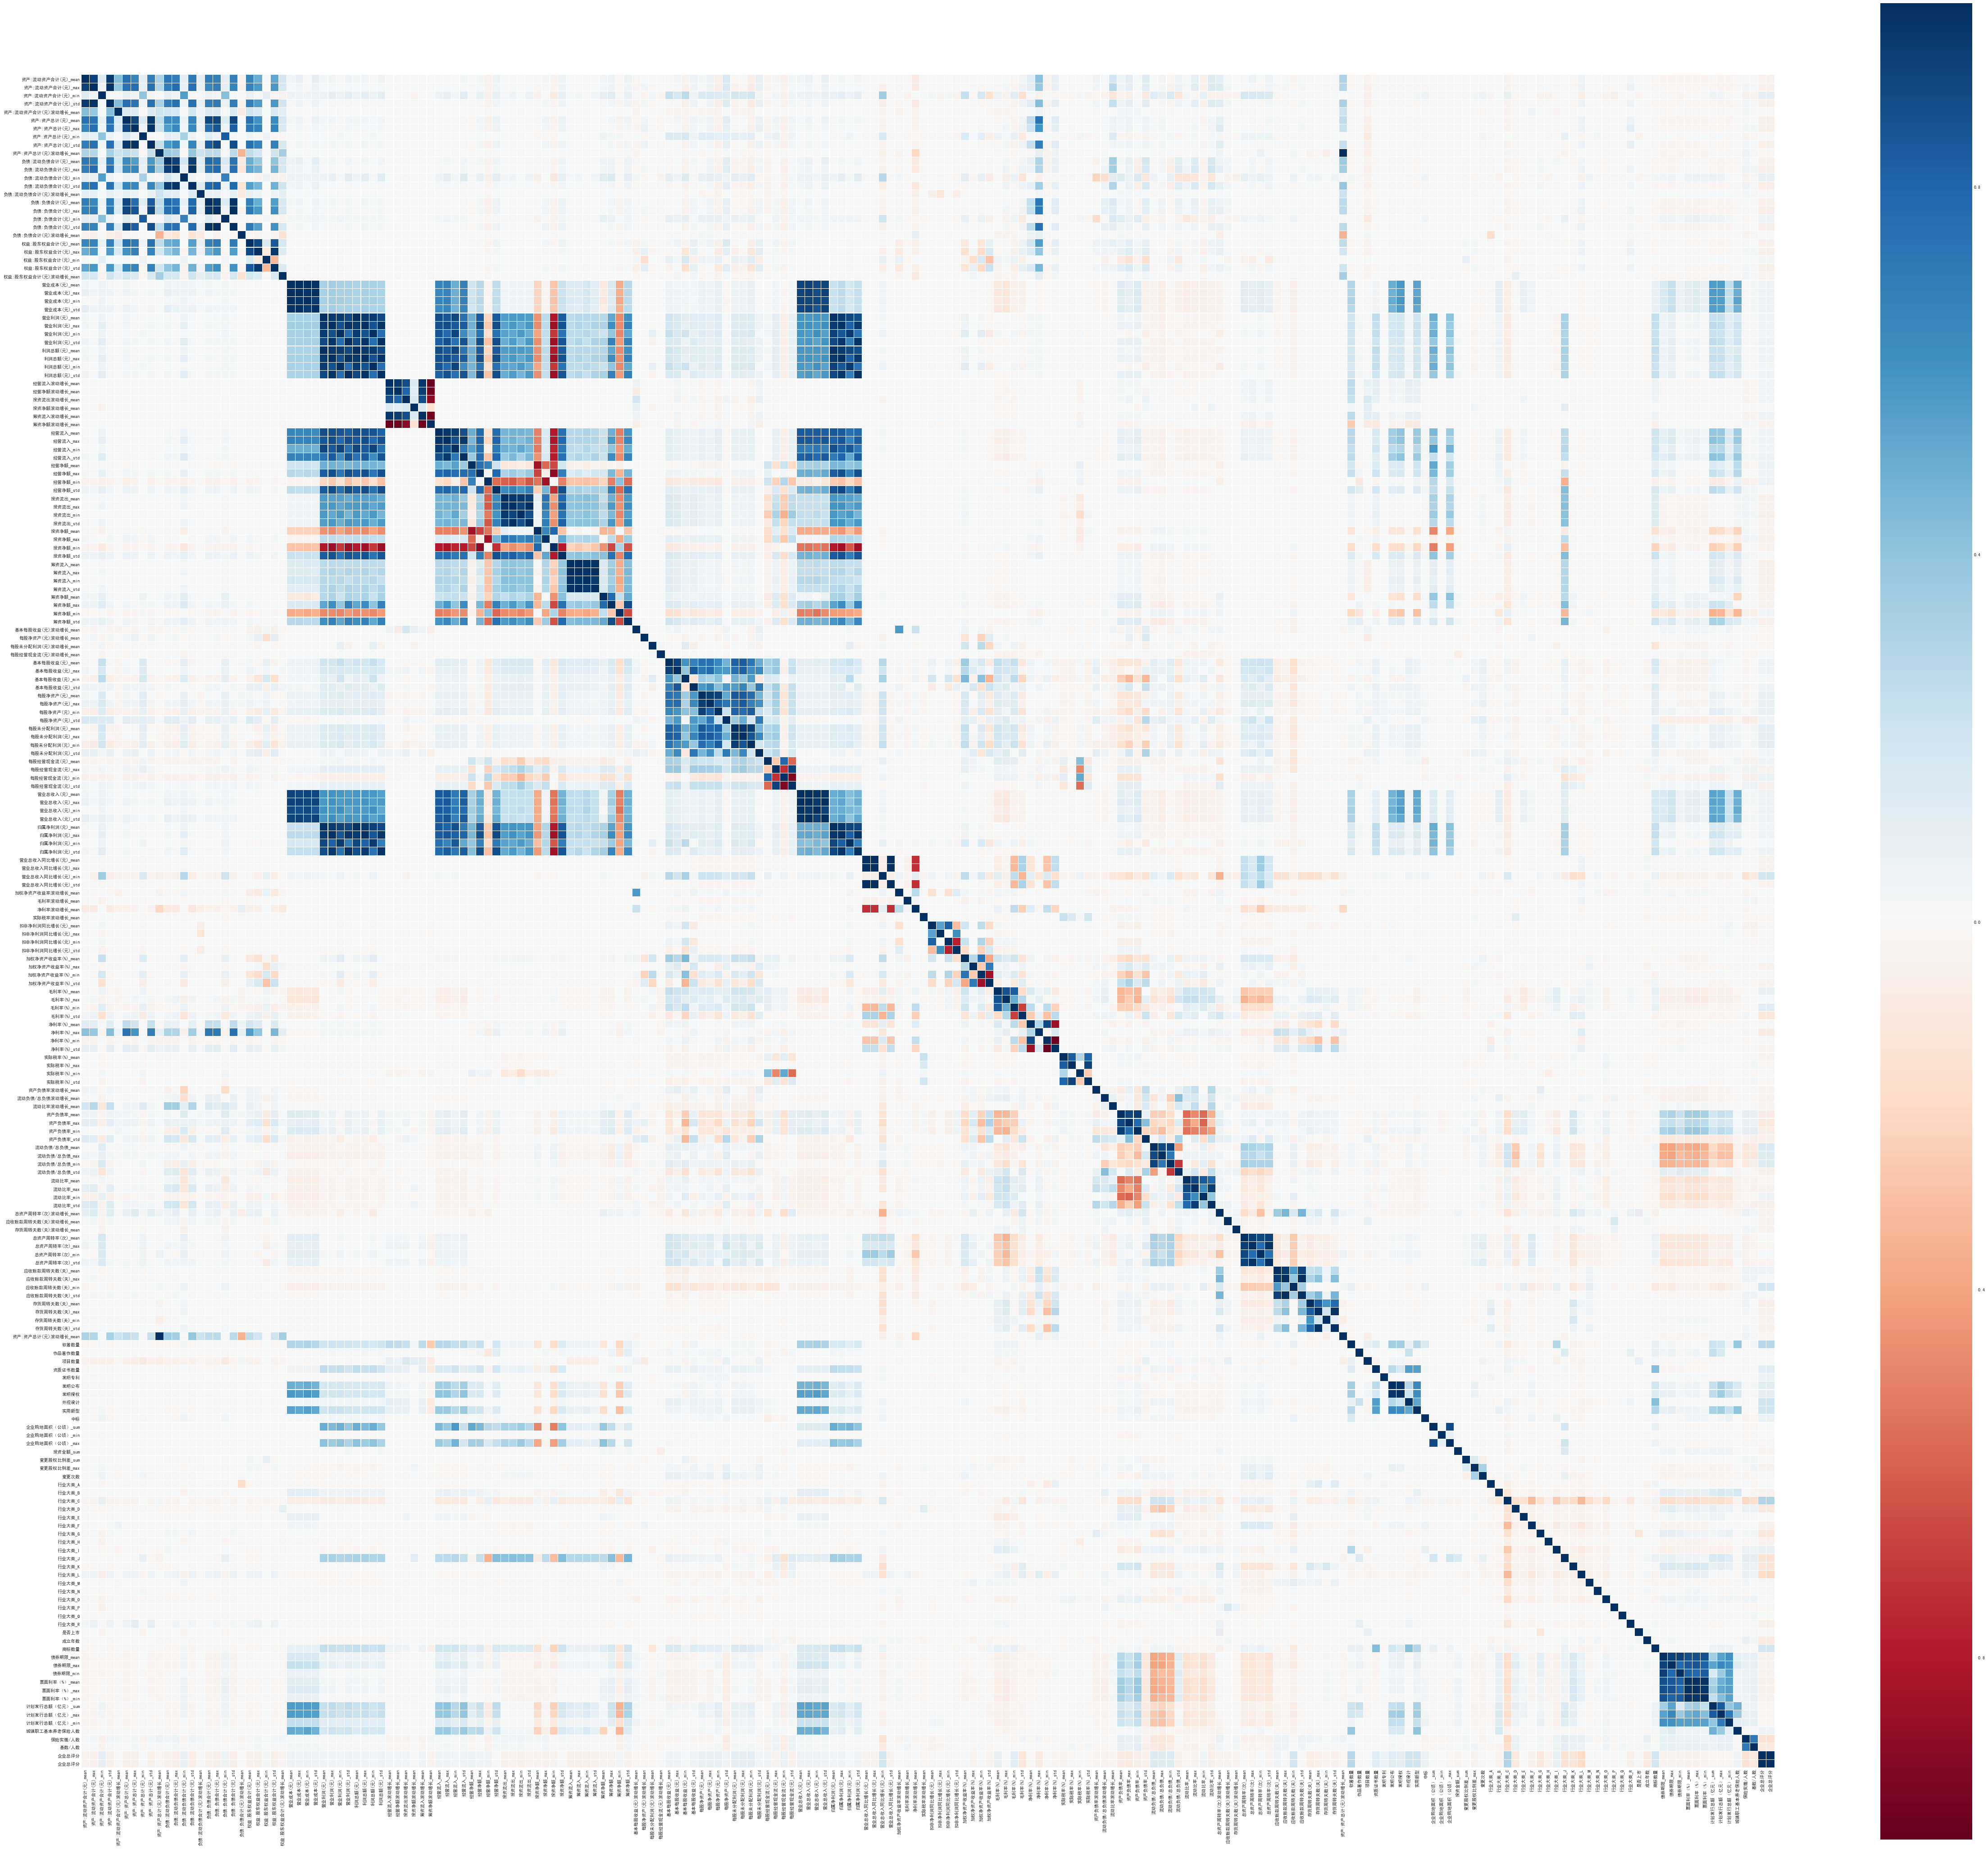

In [17]:
df_d = df.drop(['企业编号'], axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(75, 75))
sns.heatmap(df_d.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=False)

In [65]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2364, 307), (592, 307), (2364,), (592,))

In [66]:
id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

In [67]:
# sc_X = StandardScaler()
# xtrain = sc_X.fit_transform(xtrain)
# xtest = sc_X.transform(xtest)
# xtrain, xtest
xtrain = (xtrain - xtrain.mean())/xtrain.std(ddof=0)
xtest = (xtest - xtest.mean())/xtest.std(ddof=0)
xtrain.head(5)

,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,ios,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
1547,-0.203594,-0.068641,-4.233534,0.832237,0.638870,0.243157,0.613693,-0.096530,0.308585,-0.20734,...,-0.368406,-0.271078,-0.396592,-0.135414,-0.232543,-0.096991,-0.069789,-0.087406,-0.056479,-0.049408
119,-0.203594,-0.068641,4.386685,2.770570,-1.058084,-0.977275,-1.192995,-0.061086,-0.182657,-0.20734,...,0.174899,-0.006596,0.391833,-0.160421,-0.150828,-0.086878,-0.065672,-0.059961,-0.060187,-0.047187
2701,0.161024,-0.068641,0.076576,0.832237,-1.058084,0.243157,-1.192995,-0.096530,-0.182657,-0.20734,...,-0.032410,-0.141613,-0.317056,-0.079289,-0.219871,-0.126550,-0.085252,-0.104178,-0.072109,-0.043183
1450,-0.104153,-0.028693,4.386685,2.770570,-1.058084,-0.977275,2.420380,-0.096530,-0.182657,-0.20734,...,0.346674,0.648215,-0.820631,0.891284,0.089883,0.013334,0.013949,-0.038983,0.008606,-0.040227
2400,-0.203594,-0.068641,0.076576,0.832237,0.638870,0.243157,0.613693,-0.092099,-0.182657,-0.20734,...,-0.237331,-0.261730,0.036695,-0.280797,-0.159751,0.665266,0.160961,1.179755,-0.025122,-0.047431


# lightGBM

In [44]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [45]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [46]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.


KeyboardInterrupt: 

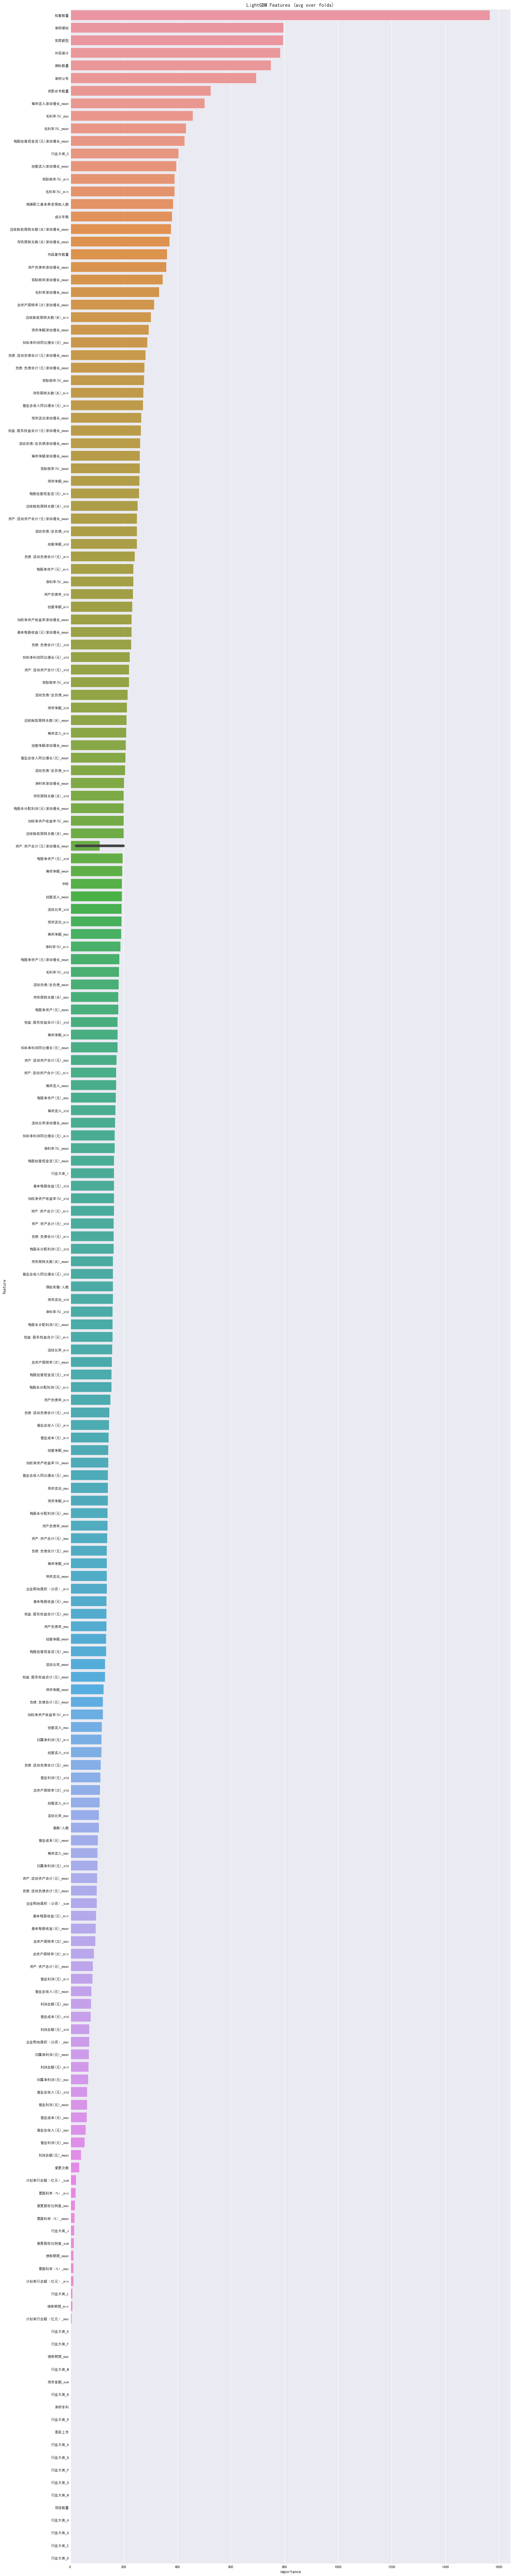

In [15]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 100))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [16]:
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

3.013483214003536

In [ ]:
# xsub = pd.DataFrame()
# xsub['企业编号'] = id_test
# xsub['企业总评分'] = mfull.astype(int)
# xsub.to_csv('sub_lgb_scaling.csv', index=False)

# Random Forest

In [54]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [55]:
ranks = {}


def ranking(ranks, names, order=1):
    stand = StandardScaler()
    ranks = stand.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [68]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(xtrain, ytrain)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').